# TEAM CONTRIBUTIONS

- Tina
- Andrew
- Rellikson

### **TINA - EDA Specialist & Data Quality Lead**
**Primary Role:** Exploratory Data Analysis and foundational data understanding  
**Responsibilities:**
- Overall dataset inspection and structure analysis
- Target variable distribution analysis (critical for imbalanced data)
- Missing value pattern identification across all variables
- Data quality assessment (duplicates, outliers, anomalies)
- Baseline statistics and distributions
- Visualization of key patterns
- Foundation insights that guide team preprocessing decisions

### **ANDREW - Categorical & Temporal Processing Specialist**
**Primary Role:** Handle categorical encoding and temporal variable transformations  
**Variables Assigned:**
- **Temporal Variables:** DAYS_BIRTH, DAYS_EMPLOYED, DAYS_REGISTRATION, DAYS_ID_PUBLISH, DAYS_LAST_PHONE_CHANGE
- **Categorical Variables:** All categorical variables (CODE_GENDER, NAME_* variables, FLAG_* variables)
- **High-Cardinality Variables:** OCCUPATION_TYPE, ORGANIZATION_TYPE (special encoding needed)
- **Missing Value Strategy:** Systematic imputation approach for all variable types
- **Document Flags:** FLAG_DOCUMENT_* variables (21 document verification flags)

### **RELLIKSON - Feature Engineering**
**Variables Assigned:**
- **ML-Derived Features:** Customer risk segments (K-means clustering), anomaly scores (Isolation Forest)
- **Advanced Transformations:** Percentile rankings, standardization for ML algorithms
- **Feature Selection:** Statistical and tree-based feature importance ranking

# CODE

In [93]:
# !pip install scikit-learn imbalanced-learn pandas numpy matplotlib seaborn joblib

In [94]:
# Import required libraries for data analysis and visualization
import pandas as pd      # for data manipulation and analysis
import numpy as np       # for numerical operations
from plotnine import *   # for grammar of graphics visualization (ggplot2 style)
import matplotlib.pyplot as plt  # for additional plotting capabilities
import warnings
from IPython.display import display
import os

# Configure display and warnings for cleaner output
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Modeling tools
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif

# Imbalanced-learn for handling class imbalance
from imblearn.over_sampling import SMOTE

In [10]:
# Set up plotnine global theme for consistent, professional-looking charts
theme_set(theme_minimal() +
          theme(figure_size=(18, 8),
                text=element_text(size=11),
                plot_title=element_text(size=16, fontweight='bold'),
                plot_subtitle=element_text(size=12, fontstyle='italic'),
                axis_title=element_text(size=12),
                axis_text=element_text(size=10),
                legend_text=element_text(size=10),
                legend_position='bottom'))

### TINA - EDA and Data Quality

In [11]:
RAW_CSV = 'Case_Data.csv' # Path to the raw data CSV file
# All outputs go here
OUT_DIR = 'processed_data'
os.makedirs(OUT_DIR, exist_ok=True)

In [12]:
# # Load and examine basic dataset information
df = pd.read_csv(RAW_CSV)
print("Dataset shape:") 
df.shape

Dataset shape:


(20000, 68)

In [2]:
# quick peek
print('\nHead:')
display(df.head())


Head:


NameError: name 'df' is not defined

In [1]:
# Classify variables by type
all_cols = df.columns.tolist()

# Get numeric and categorical variables
numeric_vars = df.select_dtypes(include=[np.number]).columns.tolist()
if 'TARGET' in numeric_vars:
    numeric_vars.remove('TARGET')

categorical_vars = df.select_dtypes(include=['object']).columns.tolist()

# Specific variable types based on naming patterns
date_vars = [col for col in numeric_vars if 'DAYS_' in col]
flag_vars = [col for col in all_cols if 'FLAG_' in col]
amt_vars = [col for col in all_cols if 'AMT_' in col]
cnt_vars = [col for col in all_cols if 'CNT_' in col]
ext_vars = [col for col in all_cols if 'EXT_SOURCE' in col]

other_numeric = [col for col in numeric_vars 
                if col not in date_vars + amt_vars + cnt_vars + ext_vars]

# Create classification summary
var_classification = {
    'Categorical': categorical_vars,
    'Financial Amounts': amt_vars,
    'Date Variables': date_vars,
    'Flag Variables': flag_vars,
    'Count Variables': cnt_vars,
    'External Scores': ext_vars,
    'Other Numeric': other_numeric
}

print("Variable Classification Summary:")
for var_type, vars_list in var_classification.items():
    print(f"  {var_type}: {len(vars_list)} variables")
    if vars_list:
        examples = ', '.join(vars_list[:3])
        if len(vars_list) > 3:
            examples += f" (and {len(vars_list)-3} more)"
        print(f"    Examples: {examples}")

NameError: name 'df' is not defined

In [14]:
print(f"Target distribution:")
print(df['TARGET'].value_counts(normalize=True))

Target distribution:
TARGET
0    0.92255
1    0.07745
Name: proportion, dtype: float64


In [15]:
# Analyze our target variable - who had payment difficulties vs who didn't
target_counts = df['TARGET'].value_counts().sort_index()
target_pct = df['TARGET'].value_counts(normalize=True).sort_index() * 100

print("Target Variable Distribution:")
print(f"  0 (No Payment Difficulties): {target_counts[0]:,} ({target_pct[0]:.1f}%)")
print(f"  1 (Payment Difficulties):    {target_counts[1]:,} ({target_pct[1]:.1f}%)")

# Prepare df for visualization
target_summary = (df.groupby('TARGET')
                 .size()
                 .reset_index(name='count')
                 .assign(
                     percentage=lambda x: round(x['count'] / x['count'].sum() * 100, 1),
                     label=lambda x: x['TARGET'].map({0: 'No Payment Difficulties', 1: 'Payment Difficulties'})
                 ))

Target Variable Distribution:
  0 (No Payment Difficulties): 18,451 (92.3%)
  1 (Payment Difficulties):    1,549 (7.7%)


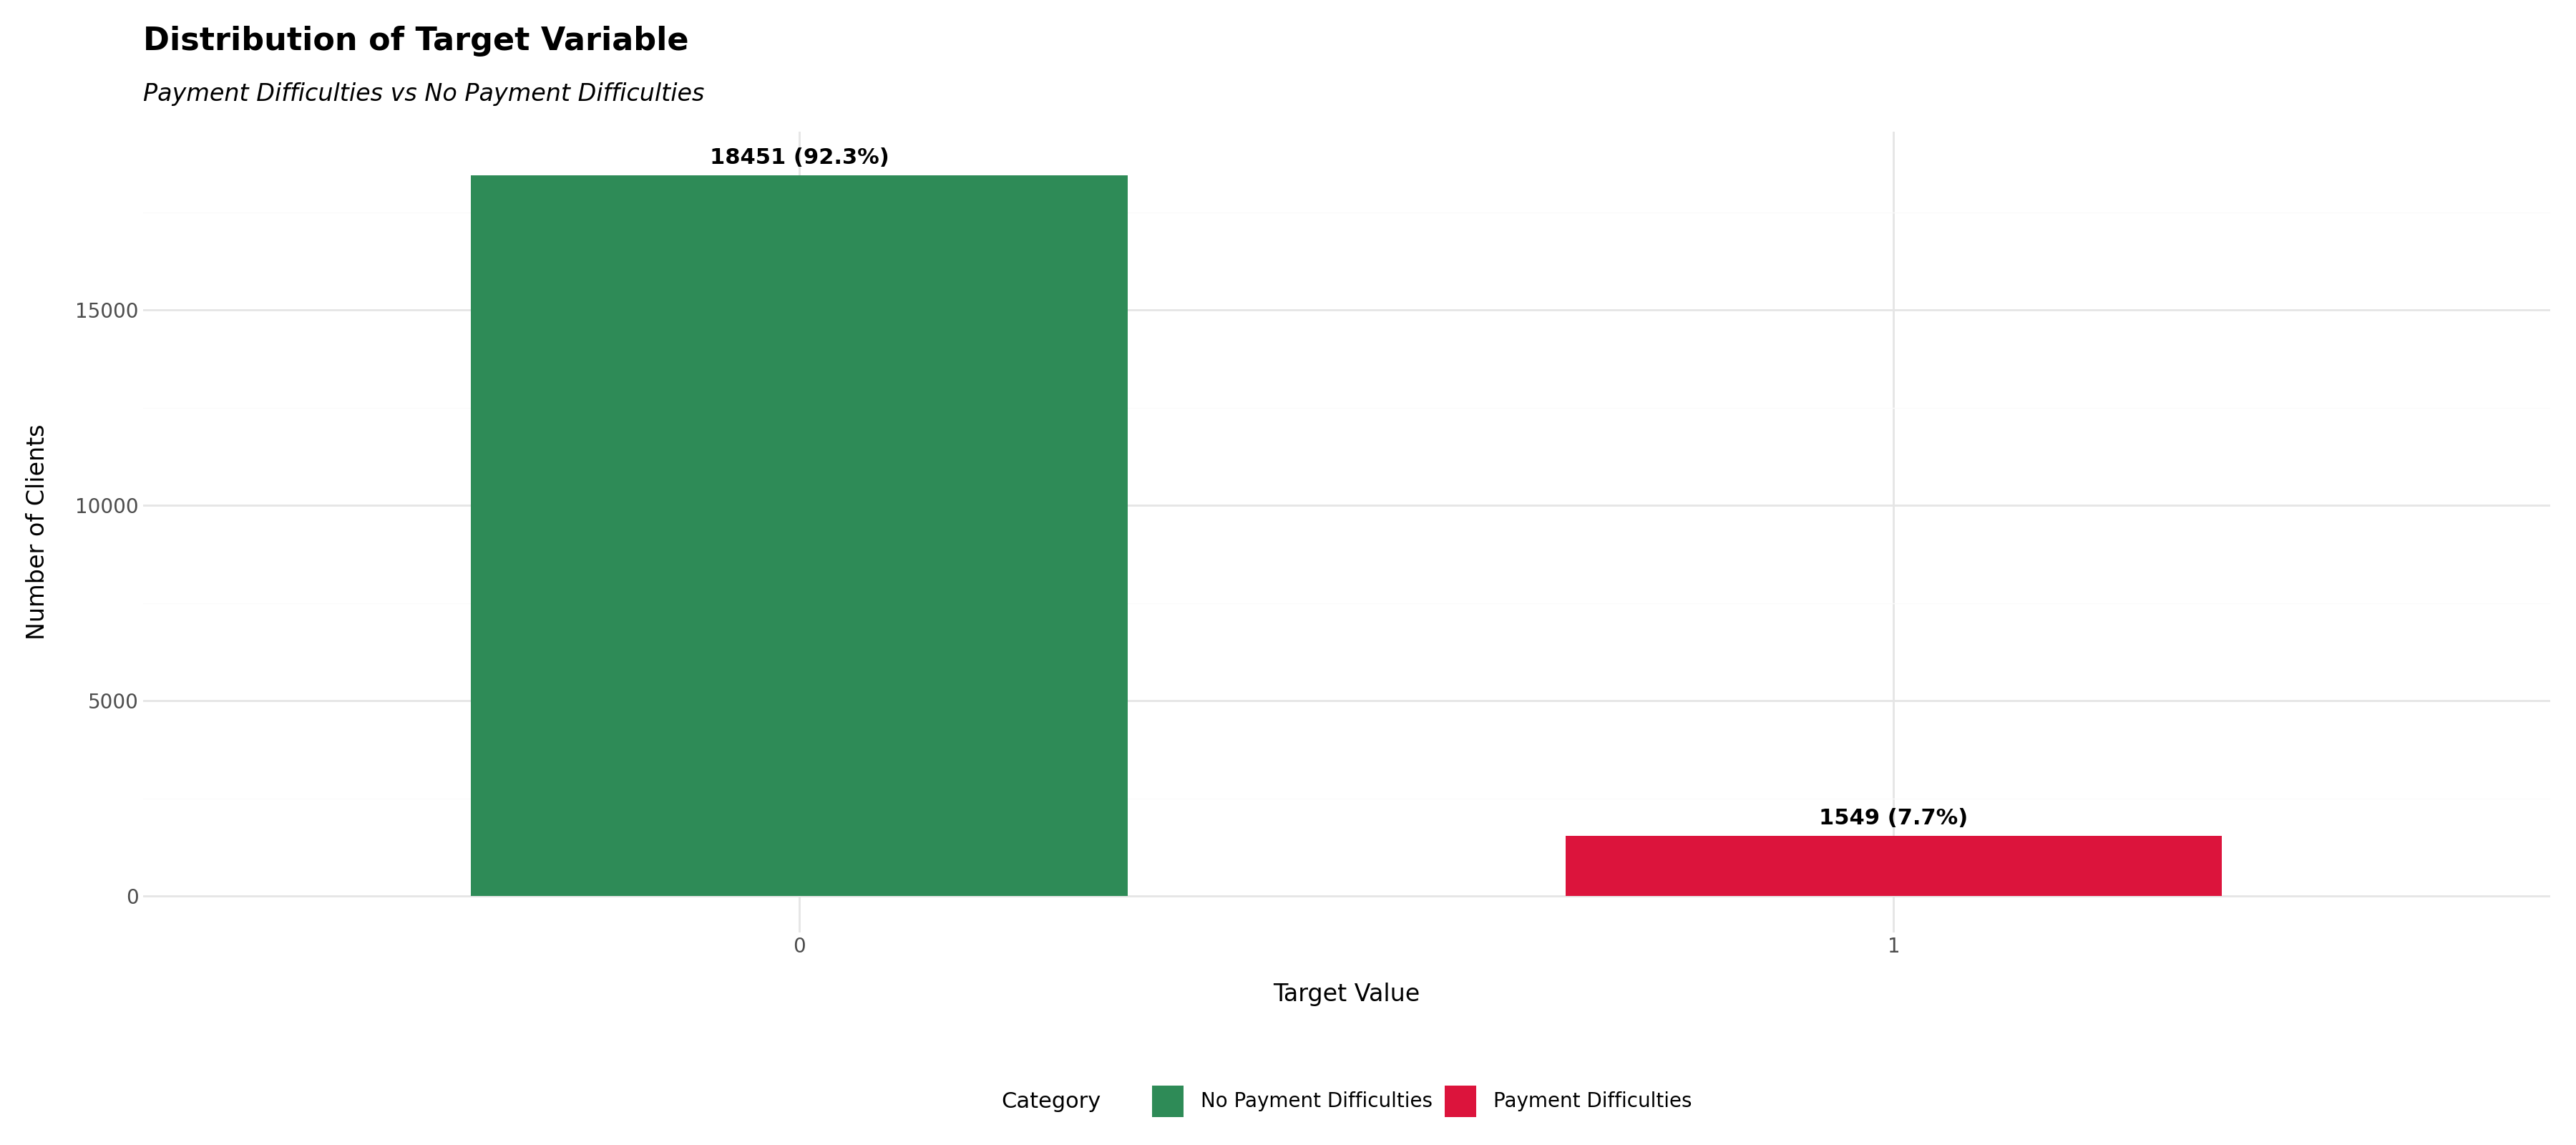

In [16]:
# Add formatted labels to dataframe for display on chart
target_summary['label_text'] = (target_summary['count'].astype(str) + 
                               ' (' + target_summary['percentage'].astype(str) + '%)')

# Create a bar chart to visualize the balance of our outcome variable
plot = (ggplot(target_summary, aes(x='factor(TARGET)', y='count', fill='label')) +
        geom_col(width=0.6) +
        # Add labels showing counts and percentages on the bars
        geom_text(aes(label='label_text'), 
                 va='bottom', nudge_y=target_summary['count'].max() * 0.01, 
                 size=11, fontweight='bold') +
        # Use green for good outcomes, red for payment difficulties
        scale_fill_manual(values={'No Payment Difficulties': '#2E8B57', 
                                'Payment Difficulties': '#DC143C'}) +
        labs(title='Distribution of Target Variable',
             subtitle='Payment Difficulties vs No Payment Difficulties',
             x='Target Value',
             y='Number of Clients',
             fill='Category'))

plot

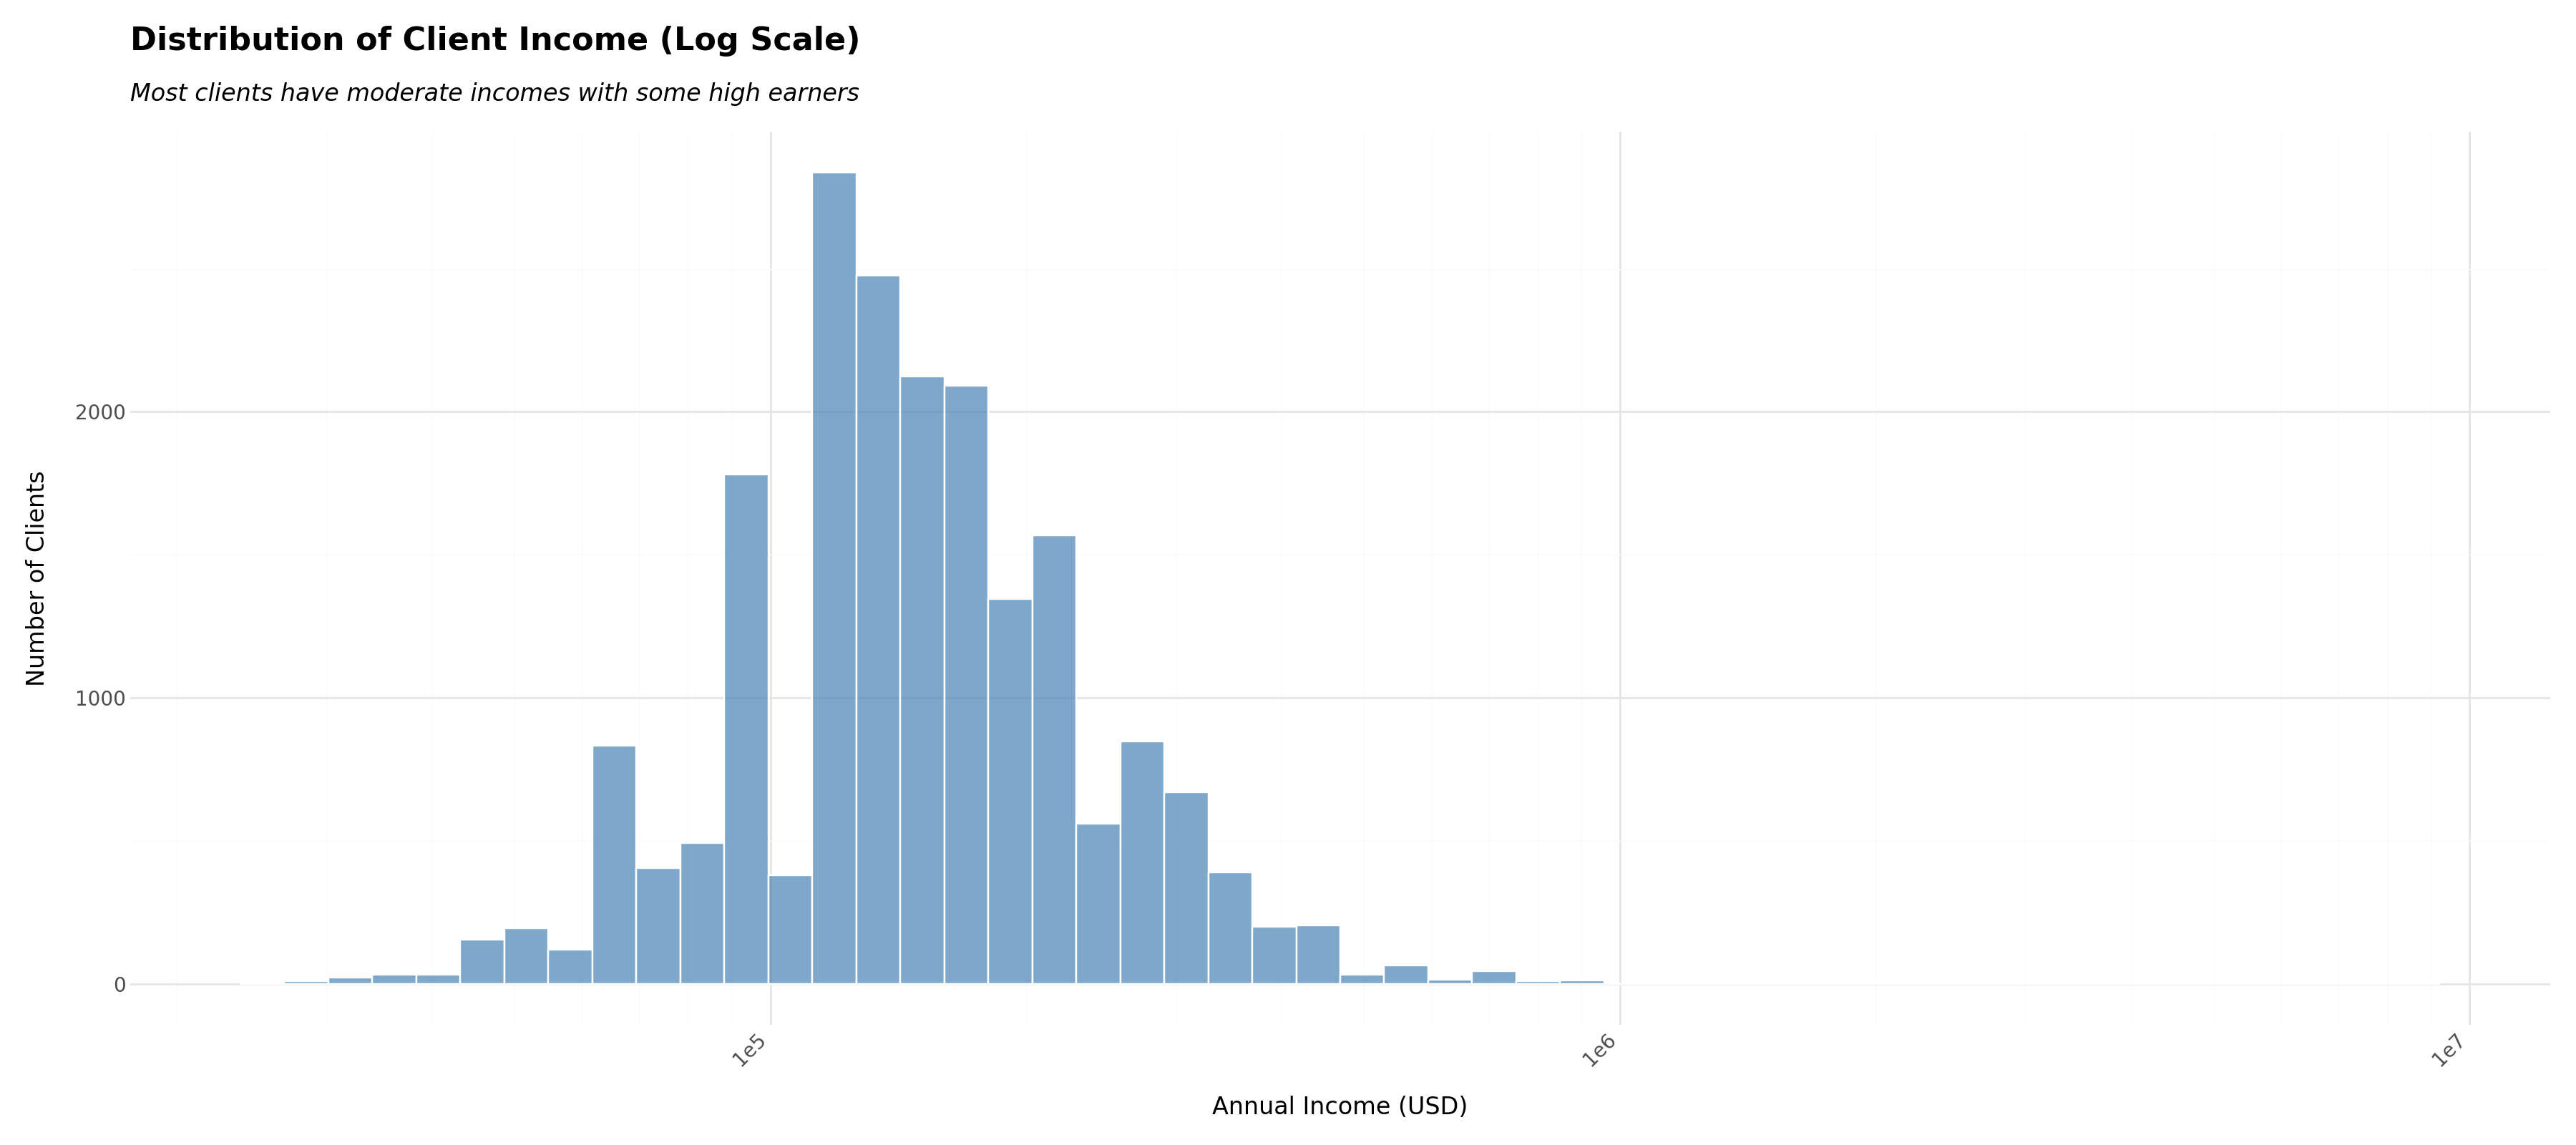

In [17]:
# Single variable analysis - Income distribution
income_data = df[df['AMT_INCOME_TOTAL'].notna() & (df['AMT_INCOME_TOTAL'] > 0)]

# Create histogram showing income distribution (log scale for better visibility)
plot = (ggplot(income_data, aes(x='AMT_INCOME_TOTAL')) +
        geom_histogram(bins=50, fill='#4682B4', alpha=0.7, color='white') +
        scale_x_log10() +  # Use log scale because income has wide range
        labs(title='Distribution of Client Income (Log Scale)',
             subtitle='Most clients have moderate incomes with some high earners',
             x='Annual Income (USD)',
             y='Number of Clients') +
        theme(axis_text_x=element_text(rotation=45, hjust=1)))
plot

In [18]:
# Missing values analysis
missing_data = df.isnull().sum()
missing_pct = (missing_data / len(df)) * 100
missing_summary = (pd.DataFrame({
    'Variable': missing_data.index,
    'Missing_Count': missing_data.values,
    'Missing_Percentage': missing_pct.values
}).query('Missing_Count > 0')
  .sort_values('Missing_Count', ascending=False))

print("Missing Values Summary:")
print(f"Total variables with missing values: {len(missing_summary)}")
print(f"Variables with >50% missing: {sum(missing_summary['Missing_Percentage'] > 50)}")
print(f"Variables with >20% missing: {sum(missing_summary['Missing_Percentage'] > 20)}")
print()

Missing Values Summary:
Total variables with missing values: 16
Variables with >50% missing: 0
Variables with >20% missing: 1



In [19]:
if len(missing_summary) > 0:
    print("Top 10 variables with most missing values:")
    display(missing_summary.head(10).round(2))
else:
    print("No missing values found in the dataset.")

Top 10 variables with most missing values:


,Variable,Missing_Count,Missing_Percentage
25,OCCUPATION_TYPE,6290,31.45
39,EXT_SOURCE_3,3945,19.73
67,AMT_REQ_CREDIT_BUREAU_YEAR,2701,13.50
66,AMT_REQ_CREDIT_BUREAU_QRT,2701,13.50
64,AMT_REQ_CREDIT_BUREAU_WEEK,2701,13.50
65,AMT_REQ_CREDIT_BUREAU_MON,2701,13.50
62,AMT_REQ_CREDIT_BUREAU_HOUR,2701,13.50
63,AMT_REQ_CREDIT_BUREAU_DAY,2701,13.50
10,NAME_TYPE_SUITE,81,0.40
40,OBS_30_CNT_SOCIAL_CIRCLE,54,0.27


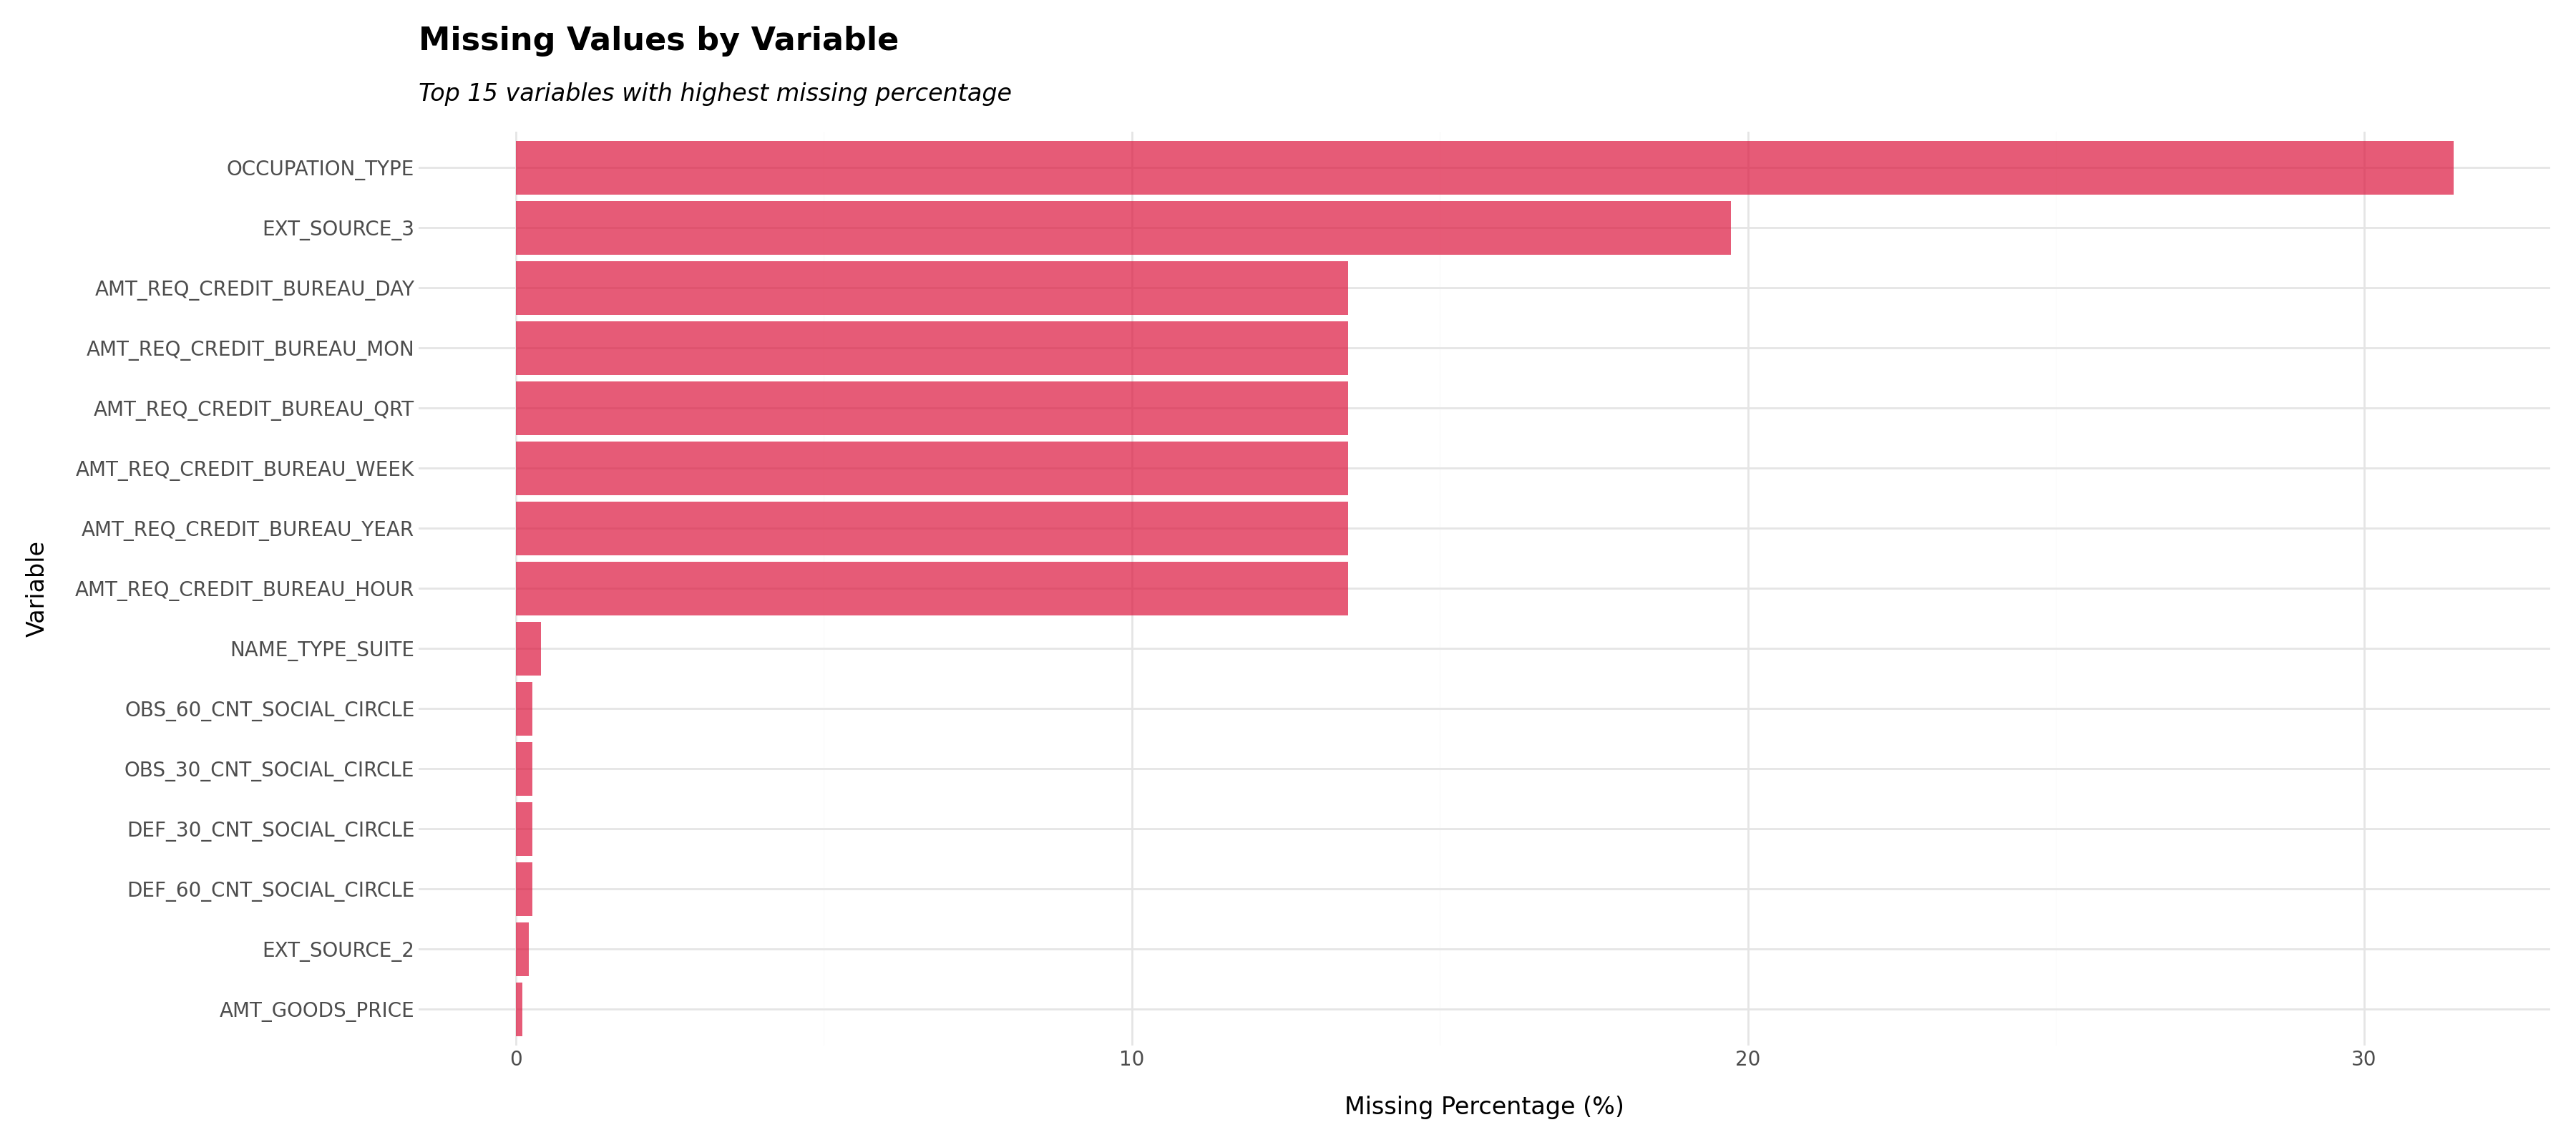

In [20]:
# Visualize missing values using plotnine
if len(missing_summary) > 0:
    top_missing = missing_summary.head(15)  # Top 15
    
    plot = (ggplot(top_missing, aes(x='reorder(Variable, Missing_Percentage)', y='Missing_Percentage')) +
            geom_col(fill='#DC143C', alpha=0.7) +
            coord_flip() +
            labs(title='Missing Values by Variable',
                 subtitle='Top 15 variables with highest missing percentage',
                 x='Variable',
                 y='Missing Percentage (%)'))
else:
    print("No missing values to visualize.")
plot

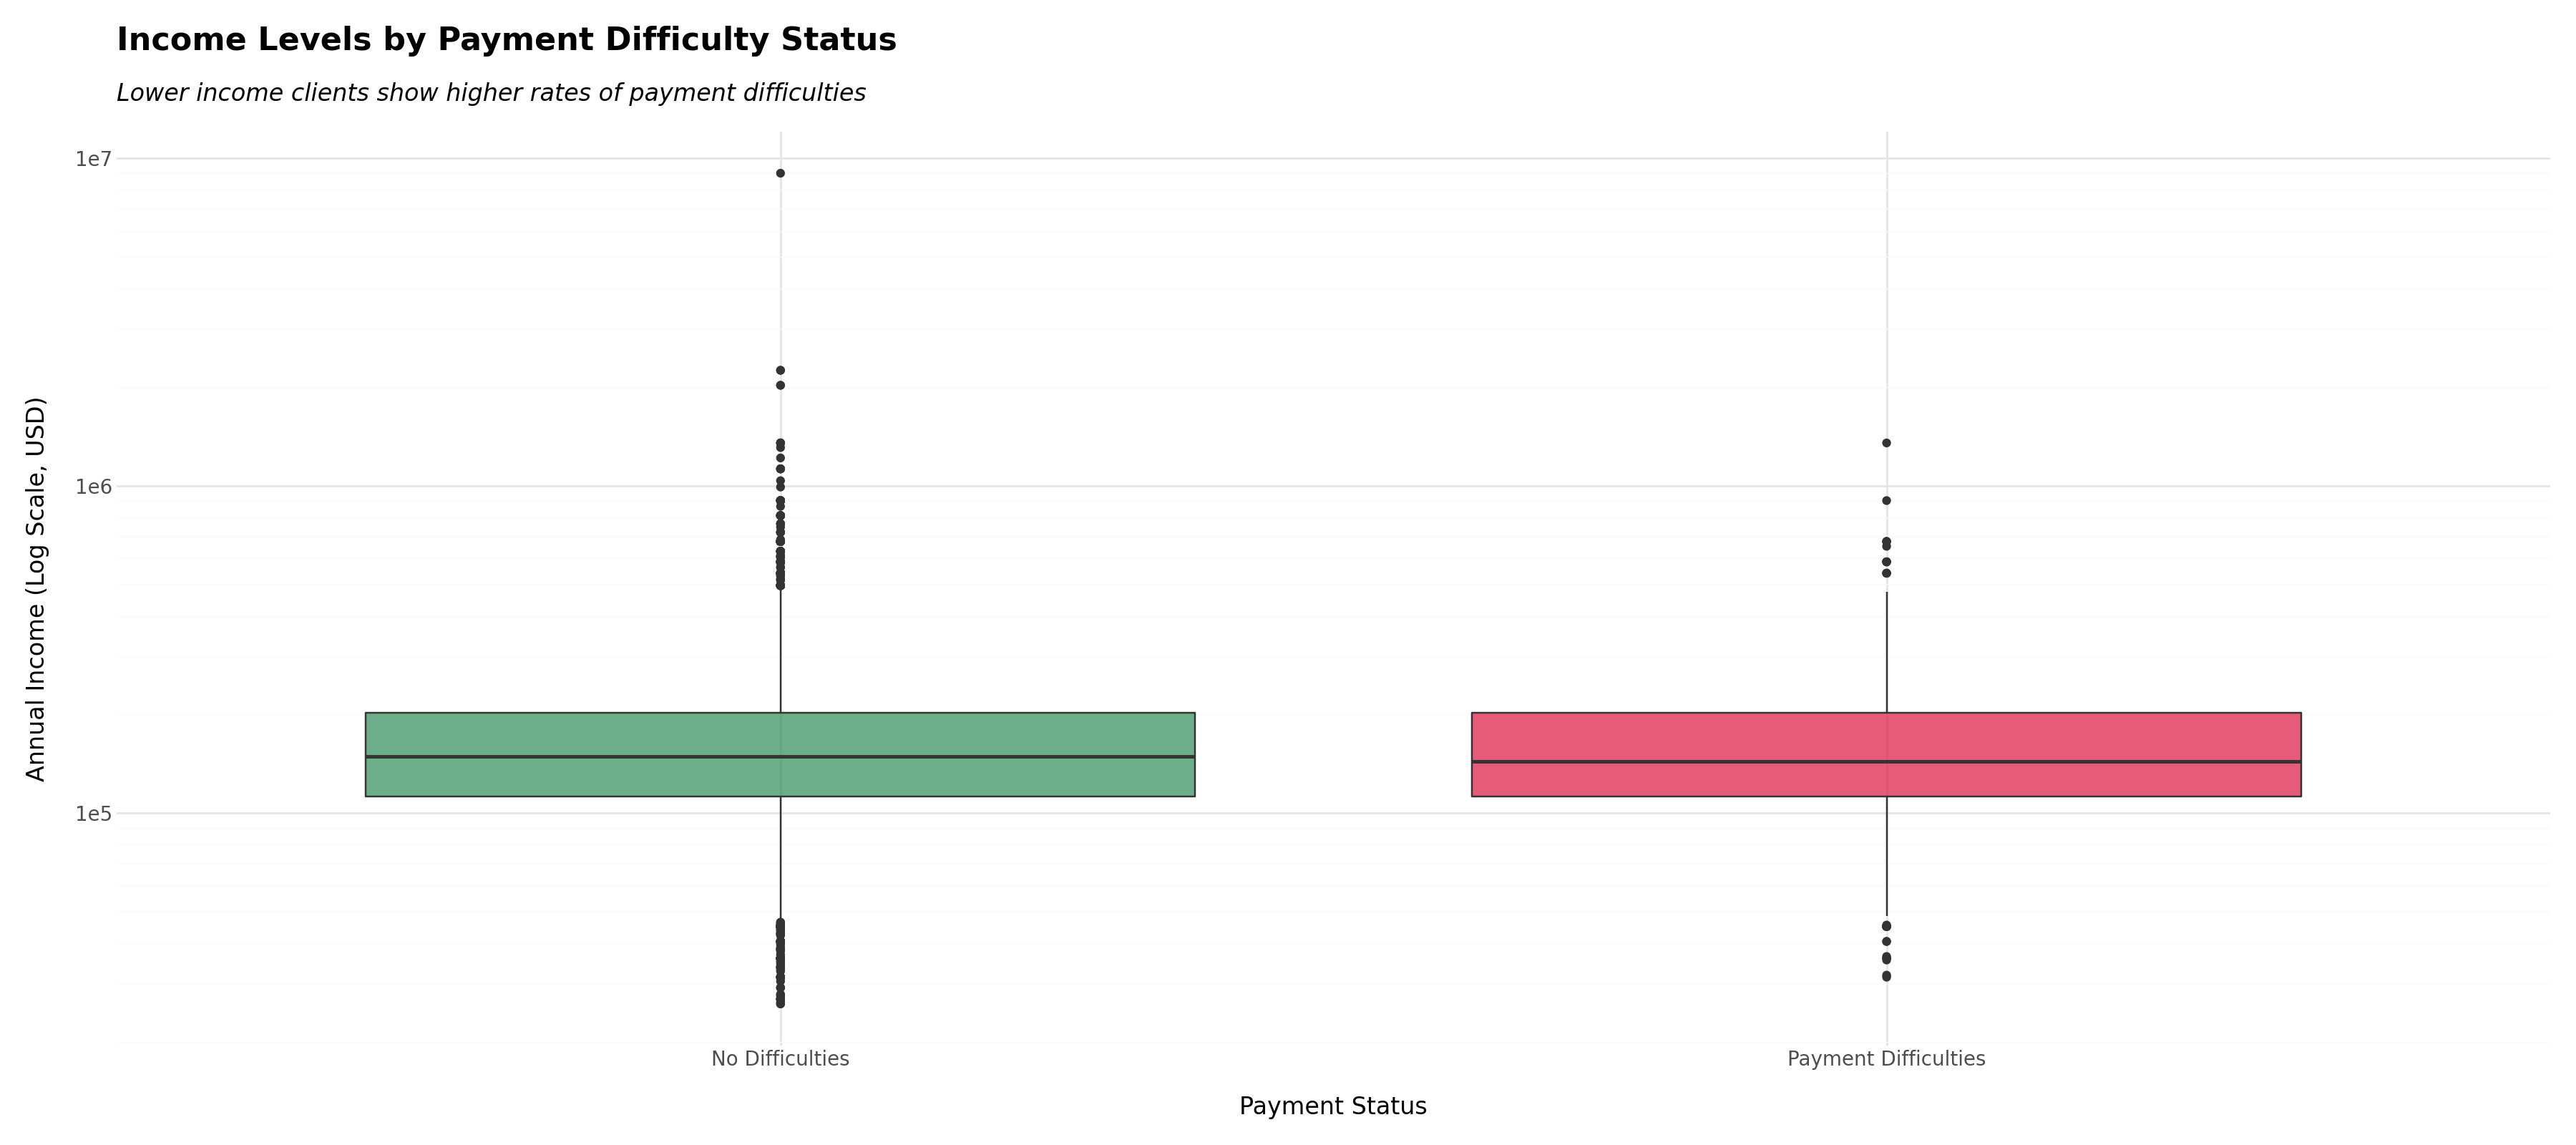

In [21]:
# Response variable relationship - Income by payment status
income_data = (df[df['AMT_INCOME_TOTAL'].notna() & (df['AMT_INCOME_TOTAL'] > 0)]
               .assign(Target_Label=lambda x: x['TARGET'].map({0: 'No Difficulties', 1: 'Payment Difficulties'})))

# Create boxplot comparing income levels between successful and struggling borrowers
plot = (ggplot(income_data, aes(x='Target_Label', y='AMT_INCOME_TOTAL', fill='Target_Label')) +
        geom_boxplot(alpha=0.7) +
        scale_y_log10() +  # Log scale for better visualization of income ranges
        scale_fill_manual(values={'No Difficulties': '#2E8B57', 'Payment Difficulties': '#DC143C'}) +
        labs(title='Income Levels by Payment Difficulty Status',
             subtitle='Lower income clients show higher rates of payment difficulties',
             x='Payment Status',
             y='Annual Income (Log Scale, USD)',
             fill='Status') +
        theme(legend_position='none'))
plot

In [22]:
# duplicate rows analysis
duplicate_count = df.duplicated().sum()
pd.DataFrame({'Duplicate_Rows': [duplicate_count]})

,Duplicate_Rows
0,0


In [23]:
# Simple outlier counts for key money fields
key_money = [c for c in ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY'] if c in df.columns]
out_rows = []
for col in key_money:
    s = df[col].dropna()
    if s.empty:
        continue
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    low, high = q1 - 1.5*iqr, q3 + 1.5*iqr
    out_count = int(((s < low) | (s > high)).sum())
    out_pct = round(out_count / len(s) * 100, 2)
    out_rows.append({'column': col, 'outliers': out_count, 'pct': out_pct})

pd.DataFrame(out_rows)

,column,outliers,pct
0,AMT_INCOME_TOTAL,882,4.41
1,AMT_CREDIT,451,2.25
2,AMT_ANNUITY,498,2.49


### ANDREW - Missing Value Handling

In [25]:
# Step 1: Data Preparation
# Create a working copy of the original data to avoid modifying the raw dataset
working_dataframe = df.copy()

# Remove any exact duplicate rows (though we found 0 duplicates earlier)
working_dataframe = working_dataframe.drop_duplicates().reset_index(drop=True)

In [55]:
# Find all columns that start with 'DAYS_' first convert them to positive years
days_cols = [c for c in working_dataframe.columns if c.startswith('DAYS_')]
days_cols

['DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'DAYS_LAST_PHONE_CHANGE']

In [56]:
# Step 2: Temporal Variable Transformation
# Convert negative days into positive years for better human interpretation
# DAYS_BIRTH: negative days from birth → positive age in years
# DAYS_EMPLOYED: negative days from employment start → positive employment years

# Convert birthdays to age: divide by 365 to get years, round to 1 decimal place
working_dataframe['AGE_YEARS'] = (-working_dataframe['DAYS_BIRTH'] / 365).round(3)

# Convert employment days to years: divide by 365 to get years, round to 1 decimal place  
working_dataframe['EMPLOYMENT_YEARS'] = (-working_dataframe['DAYS_EMPLOYED'] / 365).round(3)

# Convert registration days to years: divide by 365 to get years, round to 2 decimal places
working_dataframe['REGISTRATION_YEARS'] = (-working_dataframe['DAYS_REGISTRATION'] / 365).round(3)

# Convert days since identification to years: divide by 365 to get years, round to 2 decimal places
working_dataframe['ID_YEARS'] = (-working_dataframe['DAYS_ID_PUBLISH'] / 365).round(3)

# Convert days since last phone change to years: divide by 365 to get years, round to 2 decimal places
working_dataframe['PHONE_CHANGE_YEARS'] = (-working_dataframe['DAYS_LAST_PHONE_CHANGE'] / 365).round(3)


In [57]:
# see converted id, phone change, registration
working_dataframe[['DAYS_ID_PUBLISH', 'ID_YEARS', 'DAYS_LAST_PHONE_CHANGE', 'PHONE_CHANGE_YEARS', 'DAYS_REGISTRATION', 'REGISTRATION_YEARS']].head()

,DAYS_ID_PUBLISH,ID_YEARS,DAYS_LAST_PHONE_CHANGE,PHONE_CHANGE_YEARS,DAYS_REGISTRATION,REGISTRATION_YEARS
0,-4911,13.455,-4,0.011,-643,1.762
1,-1368,3.748,-925,2.534,-3494,9.573
2,-3866,10.592,-3,0.008,-6392,17.512
3,-2893,7.926,0,0.000,-2419,6.627
4,-2904,7.956,-397,1.088,-7846,21.496


In [27]:
# see the converted days
working_dataframe[['DAYS_BIRTH', 'AGE_YEARS', 'DAYS_EMPLOYED', 'EMPLOYMENT_YEARS']].head()

,DAYS_BIRTH,AGE_YEARS,DAYS_EMPLOYED,EMPLOYMENT_YEARS
0,-14086,38.6,-3028,8.3
1,-8728,23.9,-1157,3.2
2,-12931,35.4,-1317,3.6
3,-19334,53.0,-3494,9.6
4,-11144,30.5,-1104,3.0


In [58]:
# drop original days columns to avoid confusion
working_dataframe = working_dataframe.drop(columns=days_cols)

In [59]:
# Step 3: Column Type Identification
# After adding new temporal features (AGE_YEARS, EMPLOYMENT_YEARS), we need to 
# re-identify which columns are categorical vs numeric for proper preprocessing

# Identify categorical columns (text-based data like gender, occupation, etc.)
categorical_features = working_dataframe.select_dtypes(include=['object', 'category']).columns.tolist()

# Identify numeric columns (numbers like income, credit amount, age, etc.)
numerical_features = working_dataframe.select_dtypes(include=['number']).columns.tolist()

# Remove TARGET variable from feature lists since it's our prediction target, not a feature
TARGET = 'TARGET'
if TARGET in categorical_features:
    categorical_features.remove(TARGET)
if TARGET in numerical_features:
    numerical_features.remove(TARGET)

# Display summary of column types for verification
print(f"Categorical columns: {len(categorical_features)}")
print(f"Numeric columns: {len(numerical_features)} (now includes YEARS variables)")
print(f"Sample numeric columns: {numerical_features[:5]}")

print(f"\nSample categorical columns: {categorical_features[:5]}")

Categorical columns: 12
Numeric columns: 55 (now includes YEARS variables)
Sample numeric columns: ['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE']

Sample categorical columns: ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE']


In [60]:
# Create a summary of categorical variables showing the most frequent values for each column.
def categorical_summary(dframe: pd.DataFrame, top_n: int = 10) -> pd.DataFrame:

    # Identify all categorical columns (text-based data like gender, occupation, etc.)
    categorical_columns = dframe.select_dtypes(include=["object", "category"])
    
    rows = []
    
    # Step 3: Loop through each categorical column to analyze its values
    for column in categorical_columns.columns:
        vc = categorical_columns[column].value_counts(dropna=False).head(top_n)
        
        # For each value-count pair, create a dictionary with column name, value, and count
        for k, v in vc.items():
            rows.append({
                "column": column,    # Which categorical variable this is
                "value": k,         # The actual category value (e.g., "Male", "Manager")
                "count": int(v)     # How many times this value appears (convert to regular int)
            })
    
    # Step 5: Convert list of dictionaries to DataFrame for easy viewing and analysis
    return pd.DataFrame(rows)

# Apply the function to analyze categorical variables in our working dataset
# top_n=8 means we'll see the 8 most frequent values for each categorical column
categorical_cols_summary = categorical_summary(working_dataframe, top_n=8)

# Display the results - this shows the most common categories across all categorical variables
categorical_cols_summary


,column,value,count
0,NAME_CONTRACT_TYPE,Cash loans,18089
1,NAME_CONTRACT_TYPE,Revolving loans,1911
2,CODE_GENDER,F,13189
3,CODE_GENDER,M,6811
4,FLAG_OWN_CAR,N,13213
...,...,...,...
58,ORGANIZATION_TYPE,Self-employed,2484
59,ORGANIZATION_TYPE,Medicine,716
60,ORGANIZATION_TYPE,Business Entity Type 2,703
61,ORGANIZATION_TYPE,Government,663


In [61]:
RARE_THRESHOLD = 0.02
HIGH_CARDINALITY_VALUE = 8
TARGET = 'TARGET'

In [62]:
def categorical_unique_counts(df_to_check: pd.DataFrame, top_n: int = None) -> pd.DataFrame:
    categorical_cols = df_to_check.select_dtypes(include=['object', 'category']).columns.tolist()
    counts_df = pd.DataFrame({
        "column": categorical_cols,
        "unique_count": [df_to_check[col].nunique(dropna=False) for col in categorical_cols]
    }).sort_values("unique_count", ascending=False).reset_index(drop=True)
    if top_n is not None:
        counts_df = counts_df.head(top_n)
    return counts_df

In [63]:
# Count unique values for each categorical column
# Create and sort the DataFrame by unique_count descending
cat_unique_counts_df = categorical_unique_counts(working_dataframe)

cat_unique_counts_df

,column,unique_count
0,OCCUPATION_TYPE,11
1,ORGANIZATION_TYPE,11
2,NAME_INCOME_TYPE,8
3,NAME_TYPE_SUITE,8
4,WEEKDAY_APPR_PROCESS_START,7
5,NAME_HOUSING_TYPE,6
6,NAME_FAMILY_STATUS,5
7,NAME_EDUCATION_TYPE,5
8,FLAG_OWN_REALTY,2
9,FLAG_OWN_CAR,2


In [64]:
# Step 4: Identify High-Cardinality Categories
# Find categorical columns that have too many unique values (> 8)
# These need special treatment to avoid creating too many dummy variables
# High cardinality = many unique categories (e.g., 50+ job types)
# Low cardinality = few unique categories (e.g., Male/Female)

high_card_cols = cat_unique_counts_df[
    cat_unique_counts_df['unique_count'] > HIGH_CARDINALITY_VALUE
]['column'].tolist()
print(f"High-cardinality categorical columns (> {HIGH_CARDINALITY_VALUE} unique values):")
print(high_card_cols)

High-cardinality categorical columns (> 8 unique values):
['OCCUPATION_TYPE', 'ORGANIZATION_TYPE']


In [65]:
# Step 4b: Identify Low-Cardinality Categories  
# Find categorical columns with few unique values (<= 8)
# These can safely be one-hot encoded without creating too many features
# Examples: Gender (M/F), Car ownership (Y/N), Education level (5 types)

low_card_cols = cat_unique_counts_df[cat_unique_counts_df['unique_count'] <= HIGH_CARDINALITY_VALUE]['column'].tolist()
print(f"Low-cardinality categorical columns (<= {HIGH_CARDINALITY_VALUE} unique values):")
print(low_card_cols)

Low-cardinality categorical columns (<= 8 unique values):
['NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'WEEKDAY_APPR_PROCESS_START', 'NAME_HOUSING_TYPE', 'NAME_FAMILY_STATUS', 'NAME_EDUCATION_TYPE', 'FLAG_OWN_REALTY', 'FLAG_OWN_CAR', 'CODE_GENDER', 'NAME_CONTRACT_TYPE']


In [66]:
# Step 5: Rare Category Binning
# For high-cardinality columns only: combine rare categories into "Other"
# This prevents the model from trying to learn patterns from categories with very few examples
# RARE_THRESHOLD = 0.02 means any category appearing in < 2% of data becomes "Other"
# Example: If only 50 out of 20,000 people are "Astronauts", group them as "Other"

for col in high_card_cols:
    # Calculate frequency of each category as proportion of total data
    freq = working_dataframe[col].value_counts(normalize=True, dropna=False)
    
    # Find categories that appear less than 2% of the time
    rare_values = freq[freq < RARE_THRESHOLD].index
    
    # Replace rare values with "Other" to reduce cardinality while preserving information
    working_dataframe[col] = working_dataframe[col].where(~working_dataframe[col].isin(rare_values), "Other")

In [67]:
# CHECK: Show updated unique counts after binning
updated_cat_unique_counts_df = categorical_unique_counts(working_dataframe)
updated_cat_unique_counts_df

,column,unique_count
0,OCCUPATION_TYPE,11
1,ORGANIZATION_TYPE,11
2,NAME_INCOME_TYPE,8
3,NAME_TYPE_SUITE,8
4,WEEKDAY_APPR_PROCESS_START,7
5,NAME_HOUSING_TYPE,6
6,NAME_FAMILY_STATUS,5
7,NAME_EDUCATION_TYPE,5
8,FLAG_OWN_REALTY,2
9,FLAG_OWN_CAR,2


In [68]:
# Step 6: Build Categorical Transformer
# Create a pipeline to handle categorical variables in 2 steps:
# 1. SimpleImputer: Fill missing values with the most frequent category
#    Example: If OCCUPATION_TYPE is missing, fill with "Laborers" (most common)
# 2. OneHotEncoder: Convert categories to binary columns 
#    Example: Gender becomes Gender_M=1, Gender_F=0 for males
# handle_unknown="ignore": If new categories appear in test data, ignore them
# sparse_output=False: Return regular array instead of sparse matrix for easier handling

cat_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

In [69]:
# Step 7: Build Numerical Transformer  
# Create a pipeline to handle numeric variables in 2 steps:
# 1. SimpleImputer: Fill missing values with the median (middle value)
#    Example: If income is missing, fill with median income ($150,000)
#    We use median instead of mean because it's less affected by outliers
# 2. StandardScaler: Normalize all numeric features to have mean=0, std=1
#    Example: Age 30 might become -0.5, Age 50 might become +1.2
#    This ensures all numeric features are on the same scale for modeling

num_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Combine both transformers into a single preprocessor
# This applies the right transformation to the right type of columns automatically
preprocessor = ColumnTransformer(transformers=[
    ("num", num_transformer, numerical_features),
    ("cat", cat_transformer, categorical_features)
])

In [70]:
# Step 8: Apply Transformations and Save Results
# This is where all the preprocessing magic happens at once!

# Separate features (X) from target variable (y) for preprocessing
X = working_dataframe.drop(columns=[c for c in [TARGET] if c in working_dataframe.columns])
y = working_dataframe[TARGET] if TARGET in working_dataframe.columns else None

In [71]:
# Apply all preprocessing steps: missing value imputation, scaling, encoding
# This transforms raw messy data into clean, model-ready numeric data
X_enc = preprocessor.fit_transform(X)

# Build proper column names for the transformed data
# Numeric columns keep their original names, categorical become "Column_Category"
feature_names = []
feature_names += numerical_features
encoder = preprocessor.named_transformers_['cat'].named_steps['encoder']  
cat_feature_names = encoder.get_feature_names_out(categorical_features).tolist()
feature_names += cat_feature_names

In [72]:
# Create a clean DataFrame with proper column names and include the target
encoded_df = pd.DataFrame(X_enc, columns=feature_names, index=working_dataframe.index)
if y is not None:
    encoded_df[TARGET] = y.values

# Save Andrew's processed dataset for Rellikson's feature engineering
encoded_path = os.path.join(OUT_DIR, 'encoded_for_model.csv')
encoded_df.to_csv(encoded_path, index=False)
print('Andrew saved processed data:', encoded_path)
print(f"Shape: {encoded_df.shape}")
print(f"Ready for Rellikson's feature engineering")

Andrew saved processed data: processed_data\encoded_for_model.csv
Shape: (20000, 123)
Ready for Rellikson's feature engineering


### RELLIKSON - Feature Engineering

In [73]:
#  Step 1: Load Andrew's Processed Data
# Load the cleaned and encoded dataset that Andrew prepared
case_data = pd.read_csv(f'{OUT_DIR}/encoded_for_model.csv')
# see sample values
case_data.sample(5)

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_11,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,AGE_YEARS,EMPLOYMENT_YEARS,REGISTRATION_YEARS,ID_YEARS,PHONE_CHANGE_YEARS,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Other,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Security staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_XNA,TARGET
17676,0.808412,0.100231,1.852978,0.862164,2.179901,-0.196110,0.468442,-0.502108,0.043051,-0.618431,-0.24677,0.928123,1.854954,1.915626,-0.015528,-0.124236,-0.232538,-0.20703,-0.28761,-0.545301,-0.464628,-1.144114,0.116743,-0.608138,-0.323284,-0.606298,-0.27858,-0.007071,0.63724,-0.122145,-0.305767,-0.017323,-0.298971,-0.057976,-0.071597,-0.055311,-0.056213,-0.037443,-0.097413,-0.014144,-0.08895,-0.021218,-0.015813,-0.015813,-0.070172,-0.056317,-0.157482,-0.269975,-0.390581,-0.435659,-0.535819,0.490047,-0.128954,-1.783140,-0.831342,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
5659,-0.574552,-0.095075,-0.199903,0.192826,-0.054589,-0.196110,-2.134736,-0.502108,0.043051,-0.618431,-0.24677,-0.165588,1.85495

In [74]:
# Quick EDA checks processed data
print("Rows, Cols:", case_data.shape)
print("Target distribution (mean):", float(case_data['TARGET'].mean()))

Rows, Cols: (20000, 123)
Target distribution (mean): 0.07745


In [75]:
# Check for age-related columns (should now have AGE_YEARS after Andrew's conversion)
age_cols = [col for col in case_data.columns if 'AGE' in col.upper()]
print(f"  Age columns: {age_cols}")

  Age columns: ['AGE_YEARS', 'NAME_FAMILY_STATUS_Civil marriage', 'OCCUPATION_TYPE_Managers']


In [76]:
employment_cols = [col for col in case_data.columns if 'EMPLOYMENT' in col.upper()]
print(f"  Employment columns: {employment_cols}")

  Employment columns: ['EMPLOYMENT_YEARS']


In [77]:
income_cols = [col for col in case_data.columns if 'INCOME' in col]
print(f"  Income columns: {income_cols}")

  Income columns: ['AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE_Businessman', 'NAME_INCOME_TYPE_Commercial associate', 'NAME_INCOME_TYPE_Maternity leave', 'NAME_INCOME_TYPE_Pensioner', 'NAME_INCOME_TYPE_State servant', 'NAME_INCOME_TYPE_Student', 'NAME_INCOME_TYPE_Unemployed', 'NAME_INCOME_TYPE_Working']


In [78]:
# Show age statistics (should now show meaningful years, possibly standardized)
if age_cols:
    age_col = age_cols[0]
    age_stats = case_data[age_col].describe()[["min","mean","50%","max"]]
    print(f"\nAge statistics ({age_col}):")
    for stat, value in age_stats.items():
        print(f"  {stat}: {value:.1f}")

    # If standardized (mean near 0), explain it
    if abs(age_stats['mean']) < 1:
        print(" Data is standardized (mean≈0) - this is normal for ML!")
        print(f" Original age range was likely ~20-70 years")

# Income analysis
income_col = income_cols[0]
print(f"\nIncome analysis ({income_col}):")


Age statistics (AGE_YEARS):
  min: -1.9
  mean: 0.0
  50%: -0.1
  max: 2.1
 Data is standardized (mean≈0) - this is normal for ML!
 Original age range was likely ~20-70 years

Income analysis (AMT_INCOME_TOTAL):


In [79]:
# Use quantiles for standardized data
income_quartiles = pd.qcut(case_data[income_col], q=4, labels=['Q1-Low', 'Q2-Med-Low', 'Q3-Med-High', 'Q4-High'], duplicates='drop')
print("Default rate by income quartiles:")
quartile_defaults = case_data.groupby(income_quartiles)['TARGET'].mean()
for quartile, rate in quartile_defaults.items():
    print(f"  {quartile}: {rate:.1%}")

print(f"\nDataset ready for advanced feature engineering!")
print(f"Age and employment now in interpretable years (then standardized for ML)")

Default rate by income quartiles:
  Q1-Low: 7.9%
  Q2-Med-Low: 7.7%
  Q3-Med-High: 8.3%
  Q4-High: 6.9%

Dataset ready for advanced feature engineering!
Age and employment now in interpretable years (then standardized for ML)


In [80]:
# Quick EDA style checks (simple prints)
print("Rows, Cols:", case_data.shape)
print("Target distribution (mean):", float(case_data['TARGET'].mean()))
if "DAYS_BIRTH" in case_data.columns:
    print("Age (years) quick stats:", case_data["AGE_YEARS"].describe()[["min","mean","50%","max"]].to_dict())
if "AMT_INCOME_TOTAL" in case_data.columns:
    income_bins = pd.cut(case_data["AMT_INCOME_TOTAL"], bins=5)
    print("Default rate by income bins:\n", case_data.groupby(income_bins)["TARGET"].mean())

Rows, Cols: (20000, 123)
Target distribution (mean): 0.07745
Default rate by income bins:
 AMT_INCOME_TOTAL
(-1.314, 14.343]    0.077469
(14.343, 29.923]    0.000000
(29.923, 45.502]         NaN
(45.502, 61.081]         NaN
(61.081, 76.66]     0.000000
Name: TARGET, dtype: float64


In [81]:
# Step 2: Statistical Feature Selection  
# Use advanced statistical methods to identify the most predictive features
# This helps focus the model on the most important variables for predicting defaults

# Step 1: ANOVA F-test filtering - Find features with the strongest statistical relationship to target
# Step 2: Random Forest ranking - Use tree-based model to rank remaining features by importance
selected_features = []
X_num = case_data.drop(columns=['TARGET']).select_dtypes(include=[np.number]).fillna(0)
y_num = y

if X_num.shape[1] > 0:
    # Use ANOVA F-test to select top 200 features (or all if less than 200)
    # F-test measures how well each feature separates the target classes
    k_keep = min(200, X_num.shape[1])
    selector = SelectKBest(score_func=f_classif, k=k_keep)
    X_sel = selector.fit_transform(X_num, y_num)
    sel_cols = X_num.columns[selector.get_support()].tolist()

    # Use Random Forest to rank the selected features by importance
    # Random Forest naturally handles feature interactions and non-linear relationships
    rf = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
    rf.fit(X_num[sel_cols], y_num)
    imp = pd.Series(rf.feature_importances_, index=sel_cols).sort_values(ascending=False)

    # Keep top 75 most important features to avoid overfitting
    selected_features = imp.head(min(75, len(imp))).index.tolist()
    print("Top 10 selected features:", selected_features[:10])

Top 10 selected features: ['EXT_SOURCE_2', 'EXT_SOURCE_3', 'AGE_YEARS', 'ID_YEARS', 'REGISTRATION_YEARS', 'AMT_ANNUITY', 'PHONE_CHANGE_YEARS', 'AMT_CREDIT', 'EMPLOYMENT_YEARS', 'REGION_POPULATION_RELATIVE']


In [83]:
# Step 3: Customer Risk Clustering
# Create customer segments based on key financial characteristics
# This helps identify groups of similar customers with different risk profiles
# Clustering can reveal hidden patterns in customer behavior

# Select key variables for clustering: income, age, and credit amount
# These represent the customer's financial capacity and life stage
cluster_cols = [c for c in ["AMT_INCOME_TOTAL", "AGE_YEARS", "AMT_CREDIT"] if c in case_data.columns]

if len(cluster_cols) > 0:
    # Prepare data for clustering: fill missing values and scale features
    # Scaling is crucial for K-means since it's sensitive to variable magnitudes
    Xc = case_data[cluster_cols].fillna(0.0).values
    scaler = StandardScaler()
    Xc_scaled = scaler.fit_transform(Xc)

    # Apply K-means clustering to create 4 distinct customer segments
    # n_clusters=4: Creates Young/Old × High/Low income groups naturally
    # random_state=42: Ensures reproducible results
    kmeans = KMeans(n_clusters=4, random_state=42, n_init="auto")
    case_data["Risk_Cluster"] = kmeans.fit_predict(Xc_scaled)
else:
    case_data["Risk_Cluster"] = -1

print("Added Risk_Cluster.")

Added Risk_Cluster.


In [84]:
case_data.shape

(20000, 124)

In [ ]:
# Step 4: Anomaly Detection
# Identify customers with unusual financial patterns that might indicate higher risk
# Anomalies could represent fraud, data errors, or genuinely unusual financial situations

# Select key financial variables for anomaly detection
anom_cols = [c for c in ["AMT_INCOME_TOTAL", "AMT_CREDIT", "AMT_ANNUITY"] if c in case_data.columns]
if len(anom_cols) > 0:
    # Prepare data: fill missing values with 0 for anomaly detection
    Xa = case_data[anom_cols].fillna(0.0).values
    
    # Apply Isolation Forest algorithm for anomaly detection
    # contamination=0.10: Expect 10% of customers to be anomalous (typical for financial data)
    # Isolation Forest works by isolating outliers - anomalies are easier to separate
    iso = IsolationForest(contamination=0.10, random_state=42)
    iso_pred = iso.fit_predict(Xa)
    
    # Create anomaly score (more negative = more anomalous) and binary flag
    case_data["Anomaly_Score"] = iso.decision_function(Xa)
    case_data["Is_Anomaly"] = (iso_pred == -1)
else:
    case_data["Anomaly_Score"] = 0.0
    case_data["Is_Anomaly"] = False

# Analyze if anomalies actually correlate with payment difficulties
normal_rate = case_data.loc[~case_data["Is_Anomaly"], "TARGET"].mean()
anom_rate = case_data.loc[case_data["Is_Anomaly"], "TARGET"].mean()
print(f"Default rate normal: {normal_rate:.3f}")
print(f"Default rate anomalies: {anom_rate:.3f}")

print("Added anomaly flags.")

Default rate normal: 0.080
Default rate anomalies: 0.053
Added anomaly flags.


In [ ]:
# Step 5: Create Interaction Features
# Build new features by combining existing ones to capture complex relationships
# Interaction features can reveal patterns that individual features miss

# Product Features: Multiply related variables to capture joint effects
# Income × Credit: High income + high credit might indicate premium customers
if {"AMT_INCOME_TOTAL", "AMT_CREDIT"}.issubset(case_data.columns):
    case_data["Income_Credit_Product"] = case_data["AMT_INCOME_TOTAL"] * case_data["AMT_CREDIT"]

# Age × Income: Different income expectations at different life stages
if {"AGE_YEARS", "AMT_INCOME_TOTAL"}.issubset(case_data.columns):
    case_data["Age_Income_Product"] = case_data["AGE_YEARS"] * case_data["AMT_INCOME_TOTAL"]

# Ratio Features: Divide related variables to capture relative relationships
# Credit/Goods Ratio: How much of the purchase price is being financed?
if {"AMT_CREDIT", "AMT_GOODS_PRICE"}.issubset(case_data.columns):
    case_data["Credit_to_Goods_Ratio"] = case_data["AMT_CREDIT"] / (case_data["AMT_GOODS_PRICE"] + 1)

# Annuity/Credit Ratio: What percentage of credit becomes monthly payment?
if {"AMT_ANNUITY", "AMT_CREDIT"}.issubset(case_data.columns):
    case_data["Annuity_to_Credit_Ratio"] = case_data["AMT_ANNUITY"] / (case_data["AMT_CREDIT"] + 1)

# Document Completeness: Average of all document verification flags
# Measures how thorough the customer was in providing documentation
doc_cols = [c for c in case_data.columns if c.startswith("FLAG_DOCUMENT")]
if len(doc_cols) > 0:
    case_data["Document_Completeness_Rate"] = case_data[doc_cols].mean(axis=1)

print("Added interactions, ratios, and document completeness.")

Added interactions, ratios, and document completeness.


In [88]:
# Step 6: Final Feature Selection
# Re-run feature selection after adding new engineered features
# This ensures we identify the most predictive features including our new creations

selected_features = []
X_num = case_data.drop(columns=['TARGET']).select_dtypes(include=[np.number]).fillna(0)
y_num = y

if X_num.shape[1] > 0:
    # Apply same two-step feature selection process as before
    # Step 1: Statistical filtering with ANOVA F-test
    k_keep = min(200, X_num.shape[1])
    selector = SelectKBest(score_func=f_classif, k=k_keep)
    X_sel = selector.fit_transform(X_num, y_num)
    sel_cols = X_num.columns[selector.get_support()].tolist()

    # Step 2: Importance ranking with Random Forest
    rf = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
    rf.fit(X_num[sel_cols], y_num)
    imp = pd.Series(rf.feature_importances_, index=sel_cols).sort_values(ascending=False)

    # Select top 75 features for final modeling
    # This balances model complexity with predictive power
    selected_features = imp.head(min(75, len(imp))).index.tolist()
    print("Top 10 selected features:", selected_features[:10])

Top 10 selected features: ['EXT_SOURCE_2', 'EXT_SOURCE_3', 'ID_YEARS', 'AGE_YEARS', 'REGISTRATION_YEARS', 'Age_Income_Product', 'Anomaly_Score', 'PHONE_CHANGE_YEARS', 'AMT_ANNUITY', 'Income_Credit_Product']


In [89]:
# Step 7: Save Final Engineered Dataset
# Save the complete dataset with all engineered features for model training
# This dataset includes: original features + clusters + anomalies + interactions + ratios

# Create the engineered directory if it doesn't exist
os.makedirs("processed_data/engineered", exist_ok=True)

# Save the final engineered dataset
case_data.to_csv("processed_data/engineered/engineered.csv", index=False)
print("Saved: processed_data/engineered/engineered.csv")

Saved: processed_data/engineered/engineered.csv


In [90]:
# Step 8: Load Final Dataset for Verification
# Load the saved engineered dataset to verify everything saved correctly
# This will be the dataset used for model training and evaluation

final_data = pd.read_csv("processed_data/engineered/engineered.csv")
final_data.shape

(20000, 131)

In [95]:
# Prepare data for SMOTE
X_features = final_data.drop(columns=['TARGET'])
y_target = final_data['TARGET']

print("Before SMOTE:")
print(f"  Class 0 (No difficulties): {(y_target == 0).sum():,} samples")
print(f"  Class 1 (Payment difficulties): {(y_target == 1).sum():,} samples")
print(f"  Imbalance ratio: {(y_target == 0).sum() / (y_target == 1).sum():.1f}:1")

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42, k_neighbors=5)
X_balanced, y_balanced = smote.fit_resample(X_features, y_target)

print(f"\nAfter SMOTE:")
print(f"  Class 0 (No difficulties): {(y_balanced == 0).sum():,} samples")
print(f"  Class 1 (Payment difficulties): {(y_balanced == 1).sum():,} samples")
print(f"  New dataset shape: {X_balanced.shape}")
print(f"  Perfect balance achieved! ")

# Create balanced dataframe for saving
balanced_df = pd.DataFrame(X_balanced, columns=X_features.columns)
balanced_df['TARGET'] = y_balanced

# Save the balanced dataset
balanced_path = os.path.join(OUT_DIR, 'engineered', 'balanced_engineered.csv')
balanced_df.to_csv(balanced_path, index=False)
print(f"\n Saved balanced dataset: {balanced_path}")
print("Ready for model training with balanced classes!")

Before SMOTE:
  Class 0 (No difficulties): 18,451 samples
  Class 1 (Payment difficulties): 1,549 samples
  Imbalance ratio: 11.9:1

After SMOTE:
  Class 0 (No difficulties): 18,451 samples
  Class 1 (Payment difficulties): 18,451 samples
  New dataset shape: (36902, 130)
  Perfect balance achieved! 

 Saved balanced dataset: processed_data\engineered\balanced_engineered.csv
Ready for model training with balanced classes!
